<a href="https://colab.research.google.com/github/JJungEEun/GAN/blob/main/Paper/Pix2Pix_facades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[코드 구현] Pix2Pix 구현**
- 작성자: 정은
- 논문제목: [Image-to-Image Translation with Conditional Adversarial Networks (CVPR 2017)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf)
- 학습 데이터셋: Facade Database
- 대표적인 이미지간 도메인 변환(`Translation`) 기술인 Pix2Pix 모델을 구현한다.
- 생성기는 U-Net을, 판별기는 PatchGAN을 사용하고 있습니다.


- Reference
  + https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb
  + https://github.com/ndb796/PyTorch-Image-to-Image-Translation/blob/main/Pix2Pix_for_Facades.ipynb




---



### 1. facade dataset 불러오기

**필요한 라이브러리 불러오기**
- 실습을 위한 Pytorch 라이브러리를 불러온다

In [ ]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**학습 데이터셋 불러오기**
- 학습을 위해 깃허브에서 facade dataset 다운로드

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # 깃 클론

Cloning into 'pix2pix-pytorch'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 68 (delta 17), reused 14 (delta 14), pack-reused 45
Unpacking objects: 100% (68/68), done.


In [ ]:
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data; # 압축 풀기

- 커스텀 데이터셋(Custom Dataset) 클래스 정의

In [ ]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False): #데이터 불러오기, 변수 a는 스케치 이미지 변수 b는 실제 이미지 할당
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a') #a 이미지 경로
        self.path2b = join(path2img, 'b') #b 이미지 경로
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index): #인덱스가 주어질 때, x와 y return
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames) #데이터셋의 총 갯수 return

Dataset을 구성할 때는 PyTorch의 torch.utils.data에서 Dataset 클래스를 상속해서 만든다. 이렇게 생성된 Dataset 클래스는  __init__ 메서드, __len__ 메서드, __getitem__ 메서드 총 3개의 메서드로 구성된다. 

- <mark>__init__(self)</mark>
  + 해당 메서드의 데이터 위치, 파일명 등 초기화
  + 모든 데이터를 메모리에 로드하지 않고 효율적인 사용 가능하게 함
- <mark>__getitem__(self, index)</mark>
  + 데이터셋의 idx번째 데이터를 반환하는데 사용
  + 원본 데이터를 가져와 전처리하고 데이터를 증강하는 부분
- <mark>__len__(self)</mark>
  + Dataset의 최대 요소 수를 반환할 때 사용
  + 현재 불러오는 데이터 인덱스가 적당한 범위에 있는지 확인 가능

In [ ]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(), #image, numpy -> floattensor
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]), #정규화
                    transforms.Resize((256,256)) # 사이즈 변경
])

데이터가 항상 머신러닝 알고리즘 학습에 필요한 형태로 주어지지 않음. **변형(`transform`)**을 해서 데이터를 학습에 적합하게 만듬.

모든 TorchVision 데이터셋들 변형 로직을 갖는, 호출 가능한 객체(callable)를 받는 매개변수 두개 갖고 있음
1. 특징(feature)을 변경하기 위한 transform
2. 정답(label)을 변경하기 위한 target_transform 

torchvision.transforms 모듈은 주로 사용하는 몇가지 변형(transform)을 제공합니다.

- FashionMNIST 특징(feature)
  + PIL Image 형식이며, 정답(label)은 정수(integer)입니다
  + 학습을 하려면 정규화(normalize)된 텐서 형태의 특징(feature)과 원-핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요

이러한 변형(transformation)을 하기 위해 ToTensor 와 Lambda 를 사용합니다.

- <mark>ToTensor()</mark>
  + PIL Image나 NumPy `ndarray` 를 `FloatTensor` 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)합니다.
- <mark>Normalize(mean, std)</mark>
  + 정규화
- <mark>Resize(size)
  + 이미지의 사이즈를 size로 변경

- 학습 데이터셋 출력

In [ ]:
train_url = '/content/data/facades/train'
test_url = '/content/data/facades/test'

train = FacadeDataset(train_url, transform=transform)
test = FacadeDataset(test_url, transform=transform)

In [ ]:
print("학습 데이터셋 A와 B의 개수:", len(train))
print("테스트 데이터셋 A와 B의 개수:", len(test))

학습 데이터셋 A와 B의 개수: 400
테스트 데이터셋 A와 B의 개수: 206


- 샘플 이미지 출력
  + 왼쪽: 조건 이미지
  + 오른쪽: 정답 이미지

(-0.5, 255.5, 255.5, -0.5)

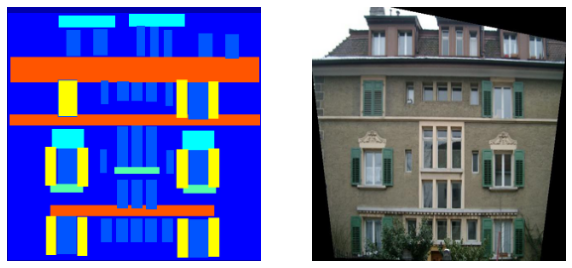

In [ ]:
a,b = train[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

### 2. 모델 구축하기


#### 생성자 구축: U-Net 아키텍처 사용

- U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
  + Contracting Path(수축단계)

In [ ]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()

        # 너비와 높이가 2배씩 감소
        # Conv2d + ReLU + InstanceNorm2d
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# check
x = torch.randn(16, 3, 256,256, device=device) #평균이 0이고 표준편차가 1인 가우시안 정규분포를 이용해 생성
model = UNetDown(3,64).to(device)
down_out = model(x)

print("기존 이미지 크기: ", x.shape)
print("다운 샘플링 이미지 크기: ",down_out.shape)

기존 이미지 크기:  torch.Size([16, 3, 256, 256])
다운 샘플링 이미지 크기:  torch.Size([16, 64, 128, 128])


- U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈
  + Expanding Path(팽창 단계)

In [ ]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()

        # 너비와 높이가 2배씩 증가       
        # Conv2d + ReLU + InstanceNorm2d

        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x

In [ ]:
# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)

print("기존 이미지 크키: ", x.shape)
print("다운 샘플링 이미지 크기: ", out.shape)

기존 이미지 크키:  torch.Size([16, 128, 64, 64])
다운 샘플링 이미지 크기:  torch.Size([16, 128, 128, 128])


- U-Net 생성자(Generator) 아키텍처: 가짜 이미지 생성

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)), # 입력 텐서 경계를 0으로 채움
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [ ]:
# check
x = torch.randn(16,3,256,256,device=device)
model = GeneratorUNet().to(device)
out = model(x)

print(out.shape)

torch.Size([16, 3, 256, 256])


In [ ]:
# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)